In [67]:
import numpy as np
import bs4
from bs4 import BeautifulSoup
from mechanize import Browser
from urllib2 import urlopen
import re
from datetime import datetime
import time
import sqlite3
import json
import time
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import sys  


In [303]:
date = datetime(year=2016, month=3, day=19)
url = "https://en.wikipedia.org/wiki/{:s}_{:d}".format(date.strftime("%B"), 19) 
page = urlopen(url)
contents = page.read()
soup = BeautifulSoup(contents, 'html.parser')

In [304]:
soup.find('span', {'id': 'Holidays_and_observances'}).find_next('ul')

<ul>\n<li>Christian <a class="mw-redirect" href="/wiki/Feast_day" title="Feast day">feast day</a>:\n<ul>\n<li><a href="/wiki/Saint_Joseph" title="Saint Joseph">Joseph of Nazareth</a> (<a href="/wiki/Western_Christianity" title="Western Christianity">Western Christianity</a>)</li>\n<li><a href="/wiki/March_19_(Eastern_Orthodox_liturgics)" title="March 19 (Eastern Orthodox liturgics)">March 19 (Eastern Orthodox liturgics)</a></li>\n</ul>\n</li>\n<li>Earliest day on which <a href="/wiki/Maundy_Thursday" title="Maundy Thursday">Maundy Thursday</a> can fall, while April 22 is the latest; celebrated on Thursday before <a href="/wiki/Easter" title="Easter">Easter</a>. (<a href="/wiki/Christianity" title="Christianity">Christianity</a>)</li>\n<li><a href="/wiki/Flag_days_in_Finland#Days_on_which_flying_the_Finnish_flag_is_an_established_custom" title="Flag days in Finland">Minna Canth's Birthday</a> (<a href="/wiki/Finland" title="Finland">Finland</a>)</li>\n<li><a href="/wiki/St_Joseph%27s_Da

In [310]:
conn = sqlite3.connect('/Users/spardy/WikipediaDates.db')
c = conn.cursor()

for month in [3]:#xrange(2, 13):
    for day in [19]:#xrange(1, 32):
        try:
            date = datetime(year=2016, month=month, day=day)
        except ValueError:
            continue

        url = "https://en.wikipedia.org/wiki/{:s}_{:d}".format(date.strftime("%B"), day) 
        page = urlopen(url)
        contents = page.read()
        soup = BeautifulSoup(contents, 'html.parser')

        #loop over non-holidays
        for _id in ['Events', 'Births', 'Deaths']:
            #Create a table, dropping the old one if it exists
            table_name = "{:s}{:d}{:d}".format(_id, month, day)
            c.execute("DROP TABLE if exists %s" % table_name)
            c.execute("CREATE TABLE %s (year, name)" % table_name)

            entries = soup.find('span', {'id': _id}).find_next('ul')
            for entry in entries:
                if (entry is not None) and (entry.name is not None):
                    m = re.match(r".*?([0-9]+) (.*)", entry.text)
                    if m is not None:
                        yr = m.groups()[0]
                        name = m.groups()[1].replace('</li>', '')
                        c.execute("INSERT INTO %s VALUES (?, ?)" % table_name, (yr, name))


        holidays = soup.find('span', {'id': 'Holidays_and_observances'}).find_next('ul')
        table_name = "{:s}{:d}{:d}".format('Holidays', month, day)
        c.execute("DROP TABLE if exists %s" % table_name)
        c.execute("CREATE TABLE %s (name)" % table_name)
        for holiday in holidays.text.split('\n'):
            if holiday != '':
                c.execute("INSERT INTO %s VALUES (?)" % table_name, (holiday,)) 

        conn.commit()

conn.close()


In [324]:
dataset = np.zeros((12, 31, 4))+np.nan

with open('/Users/spardy/Code/Web/Blog/resources/wikipedia_calendar.csv', 'w') as f:
    f.write('Date,Events,Births,Deaths,Holidays\n')
    with sqlite3.connect('/Users/spardy/WikipediaDates.db') as conn:
        c = conn.cursor()
        for month in xrange(1, 13):
            for day in xrange(1, 32):
                try:
                    date = datetime(year=2016, month=month, day=day)
                except ValueError:
                    continue
                f.write('2016-{:02d}-{:02d},'.format(month, day))
                for i, _id in enumerate(['Events', 'Births', 'Deaths']):
                    table_name = "{:s}{:d}{:d}".format(_id, month, day)
                    data = c.execute("SELECT count(*) FROM sqlite_master WHERE name ='%s' and type='table';" % table_name).fetchall()
                    if data[0][0] > 0:
                        data = c.execute("SELECT * FROM %s" % table_name).fetchall()
                        dataset[month-1, day-1, i] = len(data)
                        f.write("{:d},".format(len(data)))
                table_name = "{:s}{:d}{:d}".format('Holidays', month, day)
                data = c.execute("SELECT count(*) FROM sqlite_master WHERE name ='%s' and type='table';" % table_name).fetchall()
                if data[0][0] > 0:
                    data = c.execute("SELECT * FROM %s" % table_name).fetchall()

                    if any(['Christian feast day:' in d for d in data]):
                        dataset[month-1, day-1, 3] = len(data) - 1
                        f.write("{:d}".format(len(data) - 1))
                    else:
                        dataset[month-1, day-1, 3] = len(data)
                        f.write("{:d}".format(len(data)))
                
                f.write('\n')
        
        #print "On January {:d} there are {:d} Events, {:d} Births, {:d} Deaths, and {:d} Holidays".format(day, *nums)

In [319]:
with sqlite3.connect('/Users/spardy/WikipediaDates.db') as conn:
        c = conn.cursor()
        table_name = "{:s}{:d}{:d}".format('Holidays', 3, 16)
        data = c.execute("SELECT count(*) FROM sqlite_master WHERE name ='%s' and type='table';" % table_name).fetchall()
        if data[0][0] > 0:
            data = c.execute("SELECT * FROM %s" % table_name).fetchall()
            print data
            print any(['Christian feast day:' in d for d in data])

[(u'Christian feast day:',), (u'Abb\xe1n',), (u'Heribert of Cologne',), (u'March 16 (Eastern Orthodox liturgics)',), (u'Day of the Book Smugglers (Lithuania)',), (u'Latvian Legion Day (Latvia)',), (u"Saint Urho's Day (Finnish Americans and Finnish Canadians)",)]
True


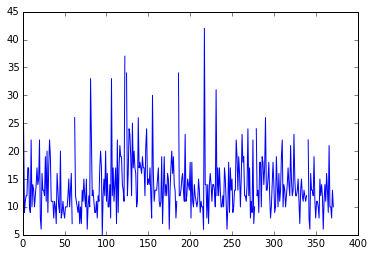

In [325]:
#plt.plot(dataset[:, :, 0].ravel())
#plt.plot(dataset[:, :, 1].ravel())
#plt.plot(dataset[:, :, 2].ravel())
plt.plot(dataset[:, :, 3].ravel())

In [326]:
for i in xrange(4):
    print np.nanmin(dataset[:, :, i]), np.nanmax(dataset[:, :, i])
    print np.nanargmin(dataset[:, :, i].ravel()), np.nanargmax(dataset[:, :, i].ravel())

30.0 156.0
198 0
109.0 735.0
59 88
56.0 418.0
59 88
5.0 42.0
95 217


### Old using EarthCalendar.net they do not allow this type of use

In [88]:
year = 2016
end_pattern = 'Copyright'
holidays = {}

for month in xrange(1, 13):
    for day in xrange(1, 31):
        try:
            date = datetime(year=year, month=month, day=day)
        except ValueError:
            continue
        
        url = "http://www.earthcalendar.net/_php/lookup.php?mode=date&m={:d}&d={:d}&y={:d}".format(month,
                                                                                           day,
                                                                                           year) 
        page = urlopen(url)
        contents = page.read()
        soup = BeautifulSoup(contents, 'html.parser')

        holidays[date] = {}

        for holiday, place in zip(soup.find_all('font', {"face": "Tahoma",
                                                 "size": "2",
                                                 "color": "#000040"})[::2],
                                     soup.find_all('font', {"face": "Tahoma",
                                                "size": "2",
                                                "color": "#000040"})[1::2]):
            if holiday.contents[0].find(end_pattern) > -1:
                break

            if isinstance(holiday.contents[0], bs4.element.Tag):
                if holiday.contents[0].name == 'a':
                    _holiday = holiday.contents[0].contents[0]
            else:
                _holiday = holiday.contents[0]
            
            if isinstance(place.contents[0], bs4.element.Tag):
                if place.contents[0].name == 'select':
                    place_list = place.contents[0].find_all('option')
                    _place = [place_entry.contents[0] for place_entry in place_list]
            else:
                _place = place.contents[0]
                
                
            holidays[date][_holiday] = _place


        

In [92]:
for day, holiday in holidays.iteritems():
    if  len(holiday.keys()) == 0:   
        print day, len(holiday.keys())

2016-02-13 00:00:00 0
2016-12-29 00:00:00 0
2016-04-20 00:00:00 0
2016-10-22 00:00:00 0
2016-02-29 00:00:00 0
2016-02-20 00:00:00 0
2016-01-23 00:00:00 0


In [93]:
for day, holiday in holidays.iteritems():
    print day, len(holiday.keys())

2016-07-18 00:00:00 2
2016-04-04 00:00:00 8
2016-09-17 00:00:00 3
2016-06-05 00:00:00 5
2016-01-10 00:00:00 1
2016-10-11 00:00:00 3
2016-08-02 00:00:00 6
2016-03-29 00:00:00 4
2016-12-20 00:00:00 3
2016-11-29 00:00:00 3
2016-01-06 00:00:00 20
2016-05-12 00:00:00 7
2016-06-17 00:00:00 4
2016-03-01 00:00:00 15
2016-09-29 00:00:00 5
2016-08-22 00:00:00 1
2016-07-15 00:00:00 3
2016-11-17 00:00:00 7
2016-10-30 00:00:00 2
2016-04-19 00:00:00 6
2016-05-20 00:00:00 5
2016-02-02 00:00:00 9
2016-09-02 00:00:00 1
2016-08-26 00:00:00 4
2016-07-27 00:00:00 4
2016-11-05 00:00:00 3
2016-06-12 00:00:00 4
2016-09-14 00:00:00 2
2016-01-19 00:00:00 2
2016-10-18 00:00:00 4
2016-03-22 00:00:00 7
2016-04-11 00:00:00 3
2016-01-15 00:00:00 2
2016-08-05 00:00:00 7
2016-07-23 00:00:00 7
2016-06-24 00:00:00 17
2016-09-26 00:00:00 1
2016-03-26 00:00:00 5
2016-10-06 00:00:00 5
2016-05-09 00:00:00 9
2016-08-09 00:00:00 5
2016-12-11 00:00:00 1
2016-02-21 00:00:00 4
2016-11-26 00:00:00 4
2016-03-14 00:00:00 8
2016-12